In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np

from math import *
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import random

from scipy.integrate import odeint
from scipy.misc import derivative

import statsmodels.formula.api as smf

from datetime import datetime
from datetime import timedelta

import itertools  

!pip install tslearn
from tslearn.metrics import soft_dtw
from tslearn.metrics import dtw

from sklearn.preprocessing import MinMaxScaler

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
def dfsn_abm(p, q, M, T):
    adopt = list()
    x = zeros((M,), float32)
    x_temp = zeros((M,), float32)
    adoptions = pd.DataFrame(arange(1,T), columns = ['time'])
    for t in range(T):
        for i in range(1,M):
            prob = (p + q * (sum(x) / M)) * (1 - x[i])
            if random.uniform(0,1) <= prob:
                x_temp[i] = 1
        x = x_temp
        adopt.append(sum(x))
    return adopt

In [4]:
def densityFunction(p, q, t):
    return (np.exp((p+q)*t)*p*(p+q)**2)/((p*np.exp((p+q)*t)+q)**2)

In [5]:
df_anchors = pd.read_csv('gdrive/My Drive/data/count_words_german_news_nov09_2021.csv')
df_anchors['Unnamed: 0'] = pd.to_datetime(df_anchors['Unnamed: 0'], utc=True)

startDate = min(df_anchors['Unnamed: 0'])
endDate   = max(df_anchors['Unnamed: 0'])
dateRange = pd.date_range(startDate, endDate, 
                          freq='MS').strftime("%Y-%b").tolist()

df_anchors['Unnamed: 0'] = dateRange
df_anchors['sum_common'] = df_anchors['sum_common'] / 10

df_anchors = df_anchors.replace(0,np.nan).dropna(axis=1,how="all")
df_anchors.fillna(0, inplace=True)
df_anchors_div = df_anchors.iloc[:, 1:]
df_anchors_div = df_anchors_div[df_anchors_div.columns[df_anchors_div.sum()>20]]


df_anchors_div = df_anchors_div.iloc[:, :-1].div(df_anchors_div['sum_common'], axis=0)
df_anchors_div.index = df_anchors['Unnamed: 0']

In [6]:
df_anchors_div.columns

Index(['Closed ecological system', 'Genetically modified organism',
       'Carbon capture and storage', '3D metal printing',
       'Radio-frequency identification', 'Intelligent tutoring system',
       'Learning Management System', 'Dynamic inductive charging',
       'E-textiles', 'Holography', 'laser diode headlights', 'Memristor',
       'Combined Cycle Gas Turbine Plant',
       'Electric vehicle battery fast charge', 'Energy harvesting',
       'Modular Reactors', 'Perovskite solar cell', 'Supercapacitor',
       'Foundation garment', 'Wearable journalism', 'Cryptocurrency', '5g',
       '6G', 'Ambient intelligence', 'Automatic AI debugging',
       'Cloud computing', 'Deep learning', 'Distributed ledger',
       'Embedded systems in substrate', 'Extreme ultraviolet lithography',
       'General-purpose computing on graphics processing units',
       'Gesture recognition', 'Indoor positioning system',
       'Internet of things', 'Machine translation',
       'Quantum computing

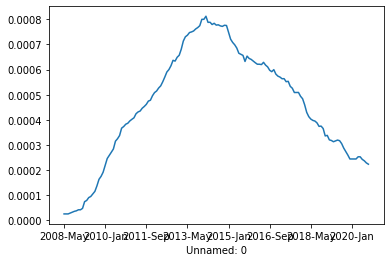

In [7]:
df_prune = df_anchors_div['e-Reader'].rolling(window=60).mean()
df_pruned = df_prune[100:]
df_pruned.plot()

In [8]:
pl = list(range(1, 20))
pl = [v*0.01 for v in pl]

ql = list(range(1, 20))
ql = [v*0.1/2 for v in ql]

t = np.linspace(1, df_pruned.shape[0]-1, df_pruned.shape[0]-1)

startDate = min(df_pruned.index)
endDate   = max(df_pruned.index)
t_months = pd.date_range(startDate, endDate, 
                             freq='MS').strftime("%Y-%b").tolist()

In [9]:
lowest = 100000

for p, q in list(itertools.product(pl, ql)):
    f = densityFunction(p, q, t)
    sim_df_cumsum = pd.DataFrame(f)
    dtw_score = dtw(sim_df_cumsum.values, df_pruned.values)
    if dtw_score < lowest:
        lowest = dtw_score
        df_ = sim_df_cumsum
        best_p = p
        best_q = q
print('best dtw score is: ', dtw_score)

best dtw score is:  0.4802819128002338


In [10]:
best_sim_df_cumsum = pd.DataFrame(densityFunction(best_p, best_q, t))

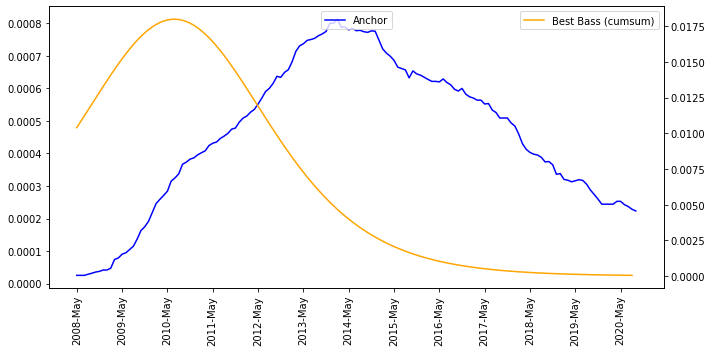

<Figure size 432x288 with 0 Axes>

In [11]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))
ax2 = ax1.twinx()
ax1.plot(df_pruned, color='blue', label='Anchor')
ax2.plot(best_sim_df_cumsum, color='orange', label='Best Bass (cumsum)')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(12))
ax1.xaxis.set_tick_params(rotation=90)
ax1.legend(loc='upper center')
ax2.legend()
plt.figure()
fig.tight_layout()
plt.show()

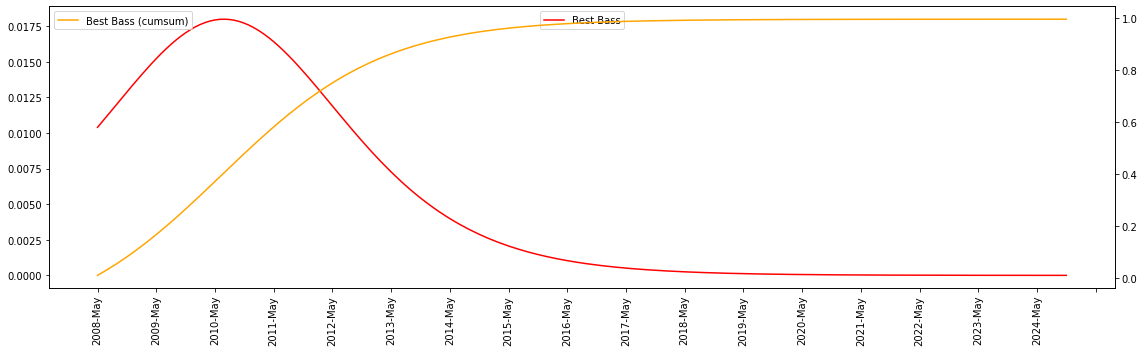

In [12]:
df_pruned.index = pd.to_datetime(df_pruned.index, utc=True)
startDateIncrease = min(df_pruned.index)
endDateIncrease = max(df_pruned.index) + timedelta(weeks=220)
dateRangeIncrease = pd.date_range(startDateIncrease, endDateIncrease,
                                  freq='MS').strftime("%Y-%b").tolist()
t_increase = np.linspace(1, len(dateRangeIncrease), len(dateRangeIncrease))

best_sim_df_increase = pd.DataFrame(densityFunction(best_p, best_q, t_increase), index=dateRangeIncrease)
best_sim_df_cumsum_increase = best_sim_df_increase.cumsum()

fig, ax1 = plt.subplots(1, 1, figsize=(16, 5))
ax2 = ax1.twinx()
ax1.plot(best_sim_df_increase, color='red', label='Best Bass')
ax2.plot(best_sim_df_cumsum_increase, color='orange', label='Best Bass (cumsum)')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(12))
ax1.xaxis.set_tick_params(rotation=90)
ax1.legend(loc='upper center')
ax2.legend()
fig.tight_layout()
plt.show()